In [1]:
import tensorflow as tf
import tools.svhn as svhn_tools
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


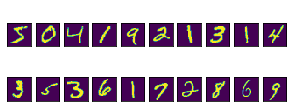

In [3]:
vis.imshow(train_images[:20], num_row=10, hspace=0, figsize=(5,2))

In [4]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 0.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/model"

seed = None

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

# gets sup_per_class samples for each class

# [10 (classes), 10 (samples), 28, 28, 1]

sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [5]:
from ipywidgets import IntProgress, Layout

graph = tf.Graph()


with graph.as_default():
    
    model = semisup.SemisupModel(arch.mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    # iterator = up.create_input(train_images, train_labels, unsup_batch_size)
    # t_unsup_images, _ = up.create_input(train_images, train_labels, unsup_batch_size)
    
    #it = up.create_input(train_images, train_labels, unsup_batch_size)
    #t_unsup_images,_ = it.get_next()
    
    unsup_data = up.create_input(train_images, train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,_ = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    #t_sup_images, t_sup_labels = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [16]:
from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="90%")) # instantiate the bar
display(f) # display the bar

with tf.Session(graph=graph) as sess:
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    
    for step in range(max_steps):
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            _, summaries = sess.run([train_op, summary_op])
            
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step + 1) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {model.step}")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='90%'), max=2000)

Step: 99
[[5531    0   23   30    6   35  162    7  118   11]
 [   0 6459   50   14    2   11   52   13   28  113]
 [  23   15 5380  168   24    9   44  113  142   40]
 [   1    9   97 5711    1   78   24   73  118   19]
 [  13   38    5    4 4327    4  115    9   86 1241]
 [  19   16   12  135    0 5001  132    1   54   51]
 [  36   18   22    0  147   77 5520    0   94    4]
 [  29   26   48   38   26   46    2 5709    9  332]
 [  12   49   32   87   16   71   90   25 5333  136]
 [  65   28   18   73  157   40    2  232   77 5257]]
Test error: 9.62 %

saving model - step <tf.Variable 'global_step:0' shape=() dtype=int64_ref>
Step: 499
[[5637    0    9    4   26   10  107    4  116   10]
 [   1 6474   55   11    8   10   47   12   32   92]
 [  46   16 5396   73   55    4   22  140  188   18]
 [   4   10  106 5607    1   88   24   80  188   23]
 [  10   35    1    1 4807    2  102    1   72  811]
 [  30   19   11   86    0 5022  156    2   47   48]
 [  49   18   16    0  138   59 5560 

In [55]:
train_step = 2000
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)

INFO:tensorflow:Restoring parameters from logs/model-2000


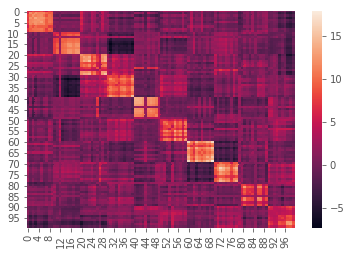

In [56]:
similarity = embedded_sup.dot(embedded_sup.T)

import matplotlib.pyplot as plt

import seaborn as sns
with plt.style.context('ggplot'):
    sns.heatmap(similarity)
    plt.savefig("figures/model_train_2000_dot.svg")

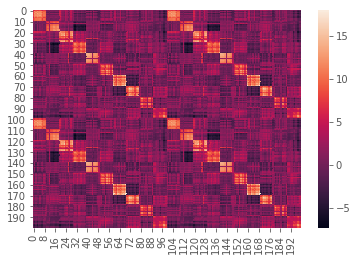

In [57]:
stacked = np.vstack((embedded_sup, embedded_sup))

similarity = stacked.dot(stacked.T)
similarity.shape

import matplotlib.pyplot as plt
# similarity[similarity<0]= 0
import seaborn as sns
with plt.style.context('ggplot'):
    sns.heatmap(similarity)
    plt.savefig("figures/model-full_2000_dot.svg")

INFO:tensorflow:Restoring parameters from logs/model-100


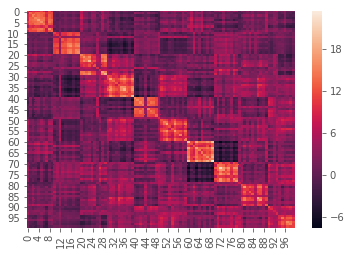

In [58]:
train_step = 100
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)
    
similarity = embedded_sup.dot(embedded_sup.T)
similarity.shape

import matplotlib.pyplot as plt

import seaborn as sns
with plt.style.context('ggplot'):
    sns.heatmap(similarity)
    plt.savefig("figures/model_train_100_dot.svg")

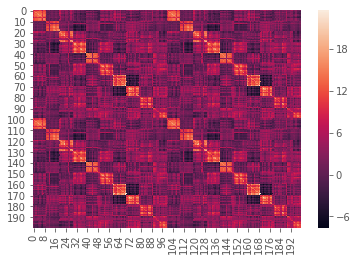

In [59]:
stacked = np.vstack((embedded_sup, embedded_sup))

similarity = stacked.dot(stacked.T)
similarity.shape

import matplotlib.pyplot as plt
# similarity[similarity<0]= 0
import seaborn as sns
with plt.style.context('ggplot'):
    sns.heatmap(similarity)
    plt.savefig("figures/model_full_100_dot.svg")

In [10]:
sq_l2_norm = np.zeros(similarity.shape)

In [11]:
sigma = 3

for idx1, ele1 in enumerate(stacked):
    for idx2, ele2 in enumerate(stacked):
        diff = ele1 - ele2
        sq_l2_norm[idx1][idx2] = np.exp(-1.*diff.dot(diff)/(2*sigma**2))

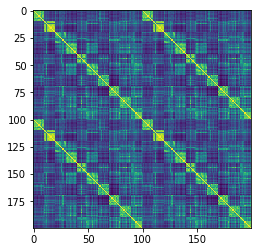

In [12]:
plt.imshow(sq_l2_norm)